# Computing Maximum Drawdown For S&P index

data source: https://datahub.io/core/s-and-p-500

In [1]:
#import package and load the file
import pandas as pd
snp=pd.read_csv("s&p_data.csv",header=0,index_col=0,parse_dates=True)
snp.head()

,SP500,Dividend,Earnings,Consumer Price Index,Long Interest Rate,Real Price,Real Dividend,Real Earnings,PE10
Date,,,,,,,,,
1871-01-01,4.44,0.26,0.4,12.46,5.32,89.00,5.21,8.02,NaN
1871-02-01,4.50,0.26,0.4,12.84,5.32,87.53,5.06,7.78,NaN
1871-03-01,4.61,0.26,0.4,13.03,5.33,88.36,4.98,7.67,NaN
1871-04-01,4.74,0.26,0.4,12.56,5.33,94.29,5.17,7.96,NaN
1871-05-01,4.86,0.26,0.4,12.27,5.33,98.93,5.29,8.14,NaN


In [2]:
snp.info() # a glance at the data set

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1768 entries, 1871-01-01 to 2018-04-01
Data columns (total 9 columns):
SP500                   1768 non-null float64
Dividend                1767 non-null float64
Earnings                1764 non-null float64
Consumer Price Index    1768 non-null float64
Long Interest Rate      1768 non-null float64
Real Price              1768 non-null float64
Real Dividend           1767 non-null float64
Real Earnings           1764 non-null float64
PE10                    1648 non-null float64
dtypes: float64(9)
memory usage: 138.1 KB


In [24]:
#select the relevant columns and fix the missing value(s)
px = snp['Real Price']
div = snp['Real Dividend']
tot_p =pd.DataFrame(px+div)
tot_r =tot_p.pct_change().dropna()
tot_r.shape

(1767, 1)

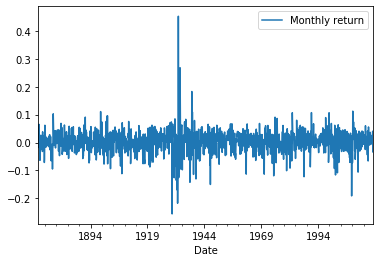

In [30]:
# plotting total return series 
tot_r.columns=['Monthly return']
tot_r.plot.line()

In [5]:
tot_r.head()
tot_r.shape

(1767, 1)

## Timeseries - forcing the index to be a datetime and make adjustments if necessary

In [6]:
tot_r.index

DatetimeIndex(['1871-02-01', '1871-03-01', '1871-04-01', '1871-05-01',
               '1871-06-01', '1871-07-01', '1871-08-01', '1871-09-01',
               '1871-10-01', '1871-11-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Date', length=1767, freq=None)

Doens't needs pd.to_datatime() adjustments

Now that the DataFrame has a datetime index, we can treat the entire dataframe as a timeseries, which makes things very convenient. For instance, we can extract just the returns in 2008 as follows:

In [7]:
tot_r["2008"]

,Monthly return
Date,
2008-01-01,-0.071152
2008-02-01,-0.019700
2008-03-01,-0.035646
2008-04-01,0.033622
2008-05-01,0.014961
2008-06-01,-0.052730
2008-07-01,-0.066125
2008-08-01,0.022893
2008-09-01,-0.047892


This is monthly data so day stamp should be removed. Use "to_period" method to fix it

In [8]:
tot_r.index = tot_r.index.to_period('M')
tot_r.head()

,Monthly return
Date,
1871-02,-0.017196
1871-03,0.008100
1871-04,0.065567
1871-05,0.047858
1871-06,0.007868


In [9]:
tot_r.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1767 entries, 1871-02 to 2018-04
Freq: M
Data columns (total 1 columns):
Monthly return    1767 non-null float64
dtypes: float64(1)
memory usage: 27.6 KB


In [10]:
tot_r.describe()

,Monthly return
count,1767.000000
mean,0.002665
std,0.038825
min,-0.255713
25%,-0.016065
50%,0.005236
75%,0.024710
max,0.452634


## Computing Drawdowns

1. Convert the time series of returns to a time series that represents a wealth index
2. Compute a time series of the previous peaks
3. Compute the Drawdown as the difference between the previous peak and the current value

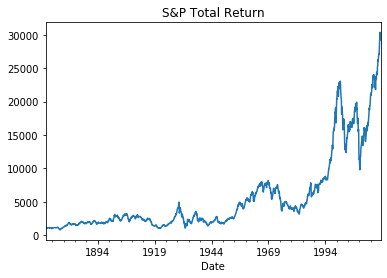

In [16]:
#calculate culmative return series
wealth_index= 1000*(1+tot_r).cumprod()
wealth_index.plot(title = 'S&P Wealth Index',legend = False)

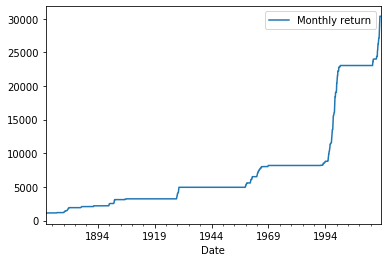

In [12]:
#calculate culmative max
previous_peaks = wealth_index.cummax()
previous_peaks.plot()

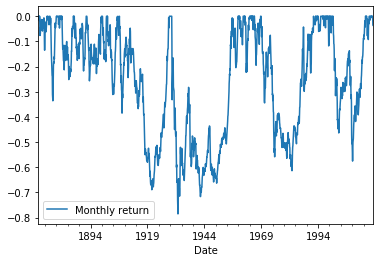

In [17]:
#calculate drawdown
drawdown = (wealth_index - previous_peaks)/previous_peaks
drawdown.plot()

In [18]:
#find max drawdown
drawdown.min()

Monthly return   -0.785751
dtype: float64

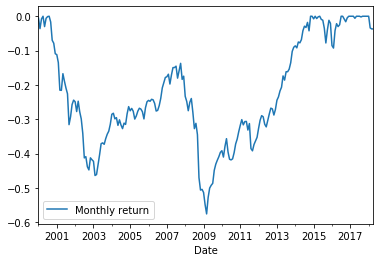

In [19]:
#drawdown post 2000
drawdown["2000":].plot()

In [20]:
drawdown["2000":].min()

Monthly return   -0.575731
dtype: float64

# Creating a Drawdown Function

In [38]:
def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the total return index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

drawdown(tot_r['Monthly return']).head()

,Wealth,Previous Peak,Drawdown
Date,,,
1871-02-01,982.804373,982.804373,0.0
1871-03-01,990.765312,990.765312,0.0
1871-04-01,1055.726568,1055.726568,0.0
1871-05-01,1106.251990,1106.251990,0.0
1871-06-01,1114.955949,1114.955949,0.0


In [39]:
drawdown(tot_r['Monthly return']).min()

Wealth           782.294873
Previous Peak    982.804373
Drawdown          -0.785751
dtype: float64

In [40]:
drawdown(tot_r['Monthly return']).idxmin()

Wealth          1877-06-01
Previous Peak   1871-02-01
Drawdown        1932-06-01
dtype: datetime64[ns]

In [42]:
drawdown(tot_r['Monthly return']['1950':]).min()

Wealth           1024.149169
Previous Peak    1024.149169
Drawdown           -0.613796
dtype: float64

In [43]:
drawdown(tot_r['Monthly return']['1950':]).idxmin()

Wealth          1950-01-01
Previous Peak   1950-01-01
Drawdown        1982-07-01
dtype: datetime64[ns]